# UNET Model for Classification

In [1]:
from importsfunctions import *

## Import train and validation dataset

In [2]:
DATAPATH = 'ISIC2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data_Resize_572_Augment/1/'
DATAPATH_segm = 'ISIC2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth_Resize_572_Augment/1/'
DATAPATH_csv='ISIC2017/ISIC-2017_Training_Part3_GroundTruth.csv'
x_train,_,y_trainclass,nomeficht=import_datasetBSrot(DATAPATH,DATAPATH_segm, DATAPATH_csv,4000)
#x_train=x_train/255

yes


In [3]:
DATAPATH = 'ISIC2017/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_Resize_5721/'
DATAPATH_segm = 'ISIC2017/ISIC-2017_Validation_Part1_GroundTruth/ISIC-2017_Validation_Part1_GroundTruth_Resize_5721/'
DATAPATH_csv='ISIC2017/ISIC-2017_Validation_Part3_GroundTruth.csv'
x_validation,_,y_validationclass,nomefichv=import_datasetBSrot(DATAPATH,DATAPATH_segm, DATAPATH_csv,150)
x_validation=x_validation/255

yes


## Create Model

### Load Model and weights

In [2]:
model_fixed = redeUNETclassfreeze(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, act='relu',complexity=32,fully=1024,pool=3)
#model_fixed.load_weights("BestSegmentatione.h5", by_name=True)
model_fixed.load_weights("Weights\Segmentation\Segmentation7_32_2.h5", by_name=True)
for layer in model_fixed.layers:
    layer.trainable= False
model_fixed.summary()  

model_class = redeUNETclassfreeze2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, act='relu',complexity=32,fully=1024,pool=3)
model_class.summary()  

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 572, 572, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 570, 570, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 568, 568, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 284, 284, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 282, 282, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 280, 280, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 140, 140, 64)      0     

### Join models

In [5]:
model_final=Sequential()
model_final.add(model_fixed)
model_final.add(model_class)
model_final.compile(optimizer=Adam(learning_rate=1e-4, amsgrad=True ),loss='categorical_crossentropy',metrics=['categorical_accuracy'],weighted_metrics=['accuracy'])
model_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 28, 28, 512)       4712224   
_________________________________________________________________
model_1 (Model)              (None, 3)                 42471427  
Total params: 47,183,651
Trainable params: 42,471,427
Non-trainable params: 4,712,224
_________________________________________________________________


## Train Model:

### Config

In [6]:
rounded_train=np.argmax(y_trainclass, axis=1)
y_validationclass2=np.argmax(y_validationclass, axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(rounded_train),rounded_train)
class_weightsV = class_weight.compute_class_weight('balanced',np.unique(y_validationclass2),y_validationclass2)
classe_weight= {0 : 1.78253119, 1 : 2.62467192, 2 : 0.48590865 }
classe_weightV= {0 : 1.66666667, 1 : 1.19047619, 2 : 0.64102564 }
train_sample_weight = np.array([classe_weight[cls] for cls in rounded_train])
val_sample_weight = np.array([classe_weightV[cls] for cls in y_validationclass2])

### CallBacks

In [7]:
Reduce=ReduceLROnPlateau(factor=0.7, patience=5, min_lr=1e-8, verbose=1)
filepath='Class_fa.h5'
filepath1='Class_fca.h5'
checkpointer = ModelCheckpoint(filepath,monitor='val_accuracy',save_weights_only=True, verbose=1, save_best_only=True)
checkpointer2 = ModelCheckpoint(filepath1,monitor='val_categorical_accuracy',save_weights_only=True, verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=50,monitor='val_accuracy', verbose=1)
log_dire = os.path.join(
    "logs",
    "freeze","tudofreeze")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dire, histogram_freq=1,profile_batch=0)


### Actual training:

Epoch 1/200
399/400 [============================>.] - ETA: 0s - loss: 5.4332 - categorical_accuracy: 0.5617 - accuracy: 0.4943
Epoch 00001: val_accuracy improved from -inf to 0.53871, saving model to Class_fa.h5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.61333, saving model to Class_fca.h5
400/400 [==============================] - 114s 285ms/step - loss: 5.4382 - categorical_accuracy: 0.5616 - accuracy: 0.4945 - val_loss: 4.3529 - val_categorical_accuracy: 0.6133 - val_accuracy: 0.5387
Epoch 2/200
399/400 [============================>.] - ETA: 0s - loss: 4.5907 - categorical_accuracy: 0.6115 - accuracy: 0.5675
Epoch 00002: val_accuracy improved from 0.53871 to 0.58535, saving model to Class_fa.h5

Epoch 00002: val_categorical_accuracy improved from 0.61333 to 0.65333, saving model to Class_fca.h5
400/400 [==============================] - 88s 220ms/step - loss: 4.5858 - categorical_accuracy: 0.6116 - accuracy: 0.5683 - val_loss: 3.7612 - val_categorical_accuracy:

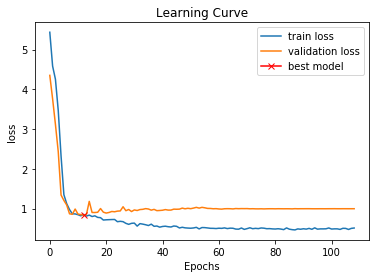

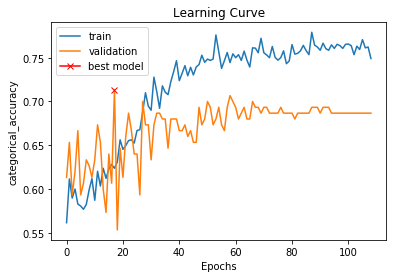

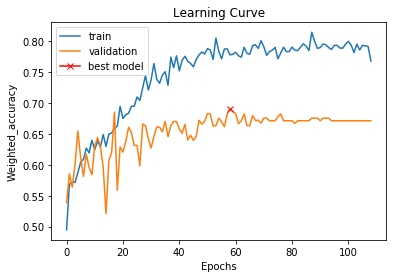

In [8]:
data_gen_args = dict(rescale=1./255, horizontal_flip=True,vertical_flip=True )
datagen = ImageDataGenerator(**data_gen_args)
it = datagen.flow(x_train, y_trainclass, sample_weight=train_sample_weight, batch_size=8,shuffle=True)
results=model_final.fit_generator(it, steps_per_epoch=2000/8,
                    validation_data=(x_validation.astype(np.float32), y_validationclass.astype(np.float32),val_sample_weight),
                    epochs=200, callbacks=[checkpointer,checkpointer2,earlystopper,Reduce,tensorboard_callback],verbose=1)
plot_performanceClassification(results)
del model_final

## Model Predictions:

In [6]:
model_final.load_weights("Class_fa.h5")

### Train Predictions and Performance:

In [7]:
predictions_train = model_final.predict(x_train,batch_size=4)
classification_metrics(predictions_train,y_trainclass)

Prediction confusion Matrix
[[ 379    0  369]
 [ 254    0  254]
 [1328    0 1416]]
Original confusion Matrix
[[ 748    0    0]
 [   0  508    0]
 [   0    0 2744]]
Sensivity[M N SK]: 0.507 . 0.516 . 0.000
Specificit[M N SK]: 0.514 . 0.504 . 1.000
Balanced_Accuracy by scikit: 0.341
Categorical Accuracy: 0.44875


### Validation Predictions and Performance:

In [8]:
predictions_val = model_final.predict(x_validation,batch_size=4)
classification_metrics(predictions_val,y_validationclass)

Prediction confusion Matrix
[[15  9  6]
 [ 5 37  0]
 [11 13 54]]
Original confusion Matrix
[[30  0  0]
 [ 0 42  0]
 [ 0  0 78]]
Sensivity[M N SK]: 0.500 . 0.692 . 0.881
Specificit[M N SK]: 0.867 . 0.917 . 0.796
Balanced_Accuracy by scikit: 0.691
Categorical Accuracy: 0.7066666666666667
